
# 📊 Descriptive Analytics: Supply Chain KPIs

**Goal:** Understand how descriptive analytics helps summarize operational performance.

**In this notebook, you will:**
1️⃣ Generate a sample **shipments dataset** (mode, distance, cost, lead time, on-time flag)  
2️⃣ Compute core **logistics KPIs** (OTIF, average lead time, transport cost share)  
3️⃣ Visualize **lead time** and **service reliability (OTIF)** by transport mode  

💡 *Use case:* Imagine you are a Supply Chain Analyst at **DHL** tracking delivery performance across Air, Sea, and Road shipments.



---
## 🔧 Setup
Install and import libraries.


In [1]:

# --- Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a consistent random seed for reproducibility
rng = np.random.default_rng(42)



---
## 🧱 1️⃣ Create a Small, Realistic Shipments Dataset
We simulate shipments with **Transport_Mode**, **Distance_km**, **Cost_EUR**, **LeadTime_days**, **SLA_days**, and **On_Time** flags.


In [8]:

# Parameters
N = 600  # number of shipments

# Transport mode distribution (most shipments go by Road)
modes = rng.choice(["Road", "Air", "Sea"], size=N, p=[0.6, 0.15, 0.25])

# Simulated shipment distances (in km)
distance_km = rng.normal(800, 300, size=N).clip(50, 5000).round(0)

# Base cost per km depending on mode (Air = expensive, Sea = cheap)
base_cost_per_km = np.where(modes == "Air", 2.0,
                            np.where(modes == "Sea", 0.5, 1.0))

# Add small random variation to simulate real cost fluctuations
cost = (distance_km * base_cost_per_km * rng.uniform(0.9, 1.1, size=N)).round(2)

# Lead time depends on distance and mode
lt_mode = np.where(modes == "Air", 2.5,
                   np.where(modes == "Sea", 18, 5))

lead_time_days = (
    lt_mode + (distance_km / 1000) * np.where(modes == "Sea", 4, 1)
    + rng.normal(0, 1, size=N)
).clip(1, 60).round(1)

# Promised SLA varies by mode
sla = np.where(modes == "Air", 3,
               np.where(modes == "Sea", 20, 5))

# Determine on-time performance (slight noise to make it realistic)
on_time = lead_time_days <= (sla + rng.integers(-1, 2, size=N))

# Combine into DataFrame
df = pd.DataFrame({
    "Shipment_ID": range(1, N + 1),
    "Transport_Mode": modes,
    "Distance_km": distance_km,
    "Cost_EUR": cost,
    "LeadTime_days": lead_time_days,
    "SLA_days": sla,
    "On_Time": on_time
})

# Preview data
df.head()


,Shipment_ID,Transport_Mode,Distance_km,Cost_EUR,LeadTime_days,SLA_days,On_Time
0,1,Air,1210.0,2609.58,4.1,3,False
1,2,Road,1287.0,1167.58,7.5,5,False
2,3,Sea,861.0,426.83,20.1,20,False
3,4,Road,972.0,1003.21,6.5,5,False
4,5,Road,754.0,812.47,6.8,5,False



---
## 📐 2️⃣ Compute Key Performance Indicators (KPIs)
We calculate:
- **OTIF (On-Time In-Full %)** → Share of shipments delivered on or before SLA  
- **Average Lead Time (days)** → Typical delivery duration  
- **Total Transport Cost (EUR)** → Total logistics spending  
These KPIs describe **“what happened”** in your supply chain.


In [9]:

# --- Overall KPI Summary ---
kpis = {
    "Total Shipments": len(df),
    "OTIF (%)": round(100 * df["On_Time"].mean(), 1),
    "Avg Lead Time (days)": round(df["LeadTime_days"].mean(), 2),
    "Total Transport Cost (EUR)": round(df["Cost_EUR"].sum(), 2)
}

print("=== 📦 Overall KPI Summary ===")
for k, v in kpis.items():
    print(f"{k}: {v}")

# --- KPI Breakdown by Transport Mode ---
mode_summary = (
    df.groupby("Transport_Mode")
      .agg(
          Shipments=("Shipment_ID", "count"),
          OTIF_pct=("On_Time", "mean"),
          Avg_LeadTime=("LeadTime_days", "mean"),
          Cost_Share=("Cost_EUR", lambda s: s.sum() / df["Cost_EUR"].sum())
      )
      .assign(
          OTIF_pct=lambda t: (100 * t["OTIF_pct"]).round(1),
          Cost_Share=lambda t: (100 * t["Cost_Share"]).round(1),
          Avg_LeadTime=lambda t: t["Avg_LeadTime"].round(1)
      )
      .sort_index()
)

mode_summary


=== 📦 Overall KPI Summary ===
Total Shipments: 600
OTIF (%): 32.0
Avg Lead Time (days): 9.31
Total Transport Cost (EUR): 497240.56


,Shipments,OTIF_pct,Avg_LeadTime,Cost_Share
Transport_Mode,,,,
Air,94,46.8,3.3,28.9
Road,354,30.2,5.8,58.2
Sea,152,27.0,21.2,12.9



---
## 📈 3️⃣ Visualize Insights
Visualization helps managers **see performance patterns** at a glance:
- Average Lead Time (days)
- OTIF (% reliability)


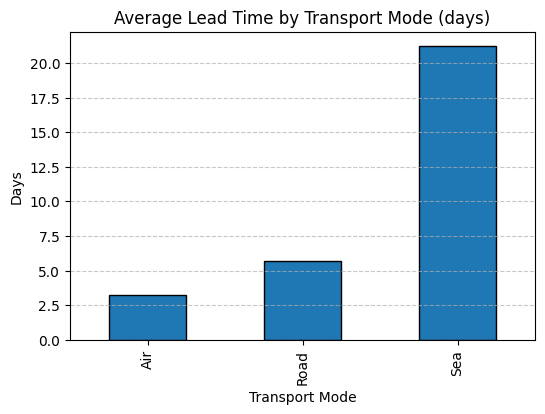

In [5]:

# --- Visualization: Average Lead Time ---
plt.figure(figsize=(6, 4))
mode_summary["Avg_LeadTime"].plot(kind="bar", edgecolor="black")
plt.title("Average Lead Time by Transport Mode (days)")
plt.ylabel("Days")
plt.xlabel("Transport Mode")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


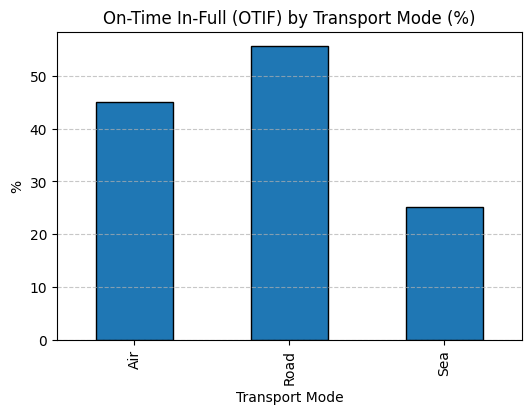

In [6]:

# --- Visualization: OTIF ---
plt.figure(figsize=(6, 4))
mode_summary["OTIF_pct"].plot(kind="bar", edgecolor="black")
plt.title("On-Time In-Full (OTIF) by Transport Mode (%)")
plt.ylabel("%")
plt.xlabel("Transport Mode")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



---
## ✅ Interpretation
- **Air shipments** are fastest but most expensive.  
- **Sea shipments** take longest but offer cost advantages.  
- **Road** shows medium cost and lead time — a balanced trade-off.  

📊 *Descriptive analytics* provides a clear snapshot of how your supply chain is performing **right now**.


